In [2]:
import torch
from torch import nn
import torchvision.models as models
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from tqdm import tqdm

In [7]:
classes = os.listdir("/kaggle/input/sports-classification/train/")

In [8]:
class ImageDataset(Dataset):
    def __init__(self, transform):
        super().__init__()
        
        self.image_dict = {}
        self.transform = transform
        encoder = LabelEncoder()
        self.classes = encoder.fit_transform(classes)
        
        for class_image, class_number in zip(classes, self.classes):
            path = os.path.join("/kaggle/input/sports-classification/train", class_image)
            path_iterate = os.listdir(os.path.join("/kaggle/input/sports-classification/train", class_image))
            images = []

            for path_it in path_iterate:
                image = os.path.join(path, path_it)
                images.append(image)


            self.image_dict[class_number] = images
    
    def __len__(self):
        return len(self.image_dict)

    
    def __getitem__(self, index):
        key = list(self.image_dict.keys())[index]
        
        image = self.transform(Image.open(self.image_dict[key][np.random.randint(0, len(self.image_dict[key]))]))
        
        return key, image

In [49]:
transform = transforms.Compose([
    transforms.Resize((124,124)),
    transforms.ToTensor()
])

In [50]:
image_dataset = ImageDataset(transform)

In [51]:
image = image_dataset.__getitem__(0)[1]

In [52]:
image = image.permute(1,2,0)
image.shape

torch.Size([124, 124, 3])

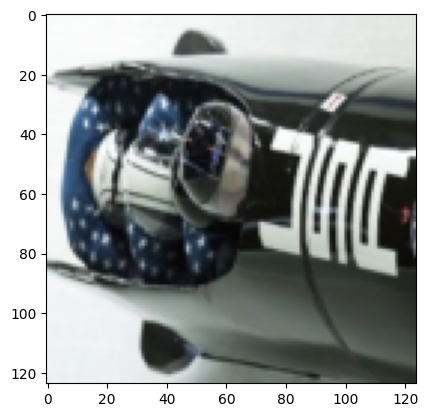

In [53]:
plt.imshow(np.array(image))
plt.show()

In [54]:
dataloader = DataLoader(image_dataset, batch_size=4, drop_last=True)

In [55]:
classs, image = next(iter(dataloader))
image.shape

torch.Size([4, 3, 124, 124])

In [56]:
encoder = LabelEncoder()
encoder.fit_transform(classes)

array([13, 45, 79, 30, 55, 75,  1, 93, 11, 35, 87, 43, 62, 29, 69, 25, 59,
       36, 91, 39, 31, 33, 17, 73, 47, 27, 70, 10, 85, 52,  4,  2,  7, 97,
       54, 53, 67, 42, 46, 32, 23, 51, 50, 94, 81,  6, 16, 44, 22, 20, 37,
       71, 61, 58, 80, 15, 57, 88, 18, 24, 12,  0, 66, 89, 56, 90, 76, 26,
       34, 64, 48, 49, 98, 14, 96, 99, 84, 63, 95,  8, 78, 92, 65, 21, 77,
       82, 38, 60, 74, 19,  9,  5, 41, 40, 86, 28, 72, 83,  3, 68])

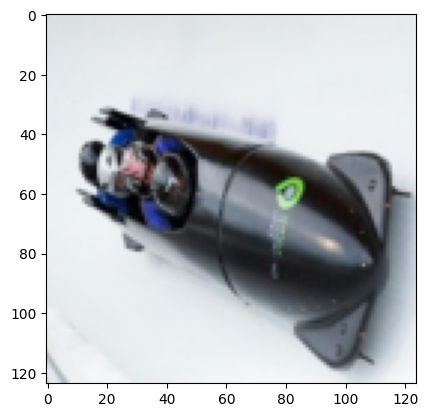

['bobsled']


In [57]:
plt.imshow(np.array(image[0].permute(1,2,0)))
plt.show()
print(encoder.inverse_transform([classs[0]]))

In [58]:
class Conv_layer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1, is_second_block=False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        
        
        self.block = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size,self.stride,padding),
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU()
        )
        
        if is_second_block:
            self.second_block = nn.Sequential(
                nn.Conv2d(self.in_channels * 2, self.out_channels, self.kernel_size, self.stride, padding),
                nn.BatchNorm2d(self.in_channels * 2),
            )
        else:
            self.second_block = nn.Sequential(
                nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size, self.stride, padding),
                nn.BatchNorm2d(self.in_channels)
            )
            
        
    def forward(self, x, prev_output=None):
        output = self.second_block(self.block(x))
        return output
        

In [59]:
def make_conv_layers():
    layers = nn.ModuleList()
    upper_limit = 34
    down_limit = 2
    
    for i in range(down_limit, upper_limit+1):
        if i >= 2 and i <= 7:
            layers.append(Conv_layer(in_channels=64, out_channels=64, kernel_size=3, padding=1))
        elif i >= 8 and i <= 15:
            if i == 8:
                layers.append(Conv_layer(in_channels=64, out_channels=128, kernel_size=3, stride=2, is_second_block=True, padding=1))
            else:
                layers.append(Conv_layer(in_channels=128, out_channels=128, kernel_size=3, padding=1))
        elif i >= 16 and i <= 28:
            if i == 16:
                layers.append(Conv_layer(in_channels=128,out_channels=256,kernel_size=3,stride=2,padding=1, is_second_block=True))
            else:
                layers.append(Conv_layer(in_channels=256, out_channels=256, kernel_size=3, padding=1))
        else:
            if i == 29:
                layers.append(Conv_layer(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1, is_second_block=True))
            else:
                layers.append(Conv_layer(in_channels=512, out_channels=512, kernel_size=3, padding=1))
    return layers

In [60]:
class ResNetModel(nn.Module):
    def __init__(self, image):
        super().__init__()
        
        self.first_block = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7,7), stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1)
        )
        
        self.first_conv_res = self.first_block(image)
        #batch_size, channels, height, width = self.first_conv_res.shape
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.final_linear = nn.Linear(512, 1000)
        
        self.layers = make_conv_layers()
        
        self.skip_connection = self.first_conv_res
        
        self.softmax_layer = nn.Linear(1000, 100)
        self.softmax = nn.Softmax(dim=0)
        
        
    
    def forward(self, x):
        x = self.first_block(x)
        count = 1
        for layer in self.layers:
            x = layer(x)
            self.skip_connection = x.clone()
            x += self.skip_connection
            
        x = self.avg_pool(x)
        reshaped_input = x.view(x.size(0), -1)
        
        
        x = self.final_linear(reshaped_input)
        
        x = self.softmax(self.softmax_layer(x))
        
        return x

In [61]:
resnet = ResNetModel(image)

In [62]:
result = resnet(image)
result.shape

torch.Size([4, 100])

In [73]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(resnet.parameters(), lr=learning_rate)

In [74]:
loss_fn = nn.CrossEntropyLoss()

In [75]:
epochs = 100

In [76]:
def train():
    count = 0
    resnet.train()
    for epoch in range(epochs):
        for labels, images in tqdm(dataloader):
            outputs = resnet(images)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            count += 1
        print(f"loss: {loss.item()}")
        count = 0

In [77]:
train()

100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


loss: 4.914885520935059


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


loss: 4.664877891540527


100%|██████████| 25/25 [00:10<00:00,  2.36it/s]


loss: 4.9146928787231445


100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


loss: 4.6646928787231445


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


loss: 4.9146928787231445


100%|██████████| 25/25 [00:10<00:00,  2.36it/s]


loss: 4.9146928787231445


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


loss: 4.9146928787231445


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


loss: 4.6646928787231445


100%|██████████| 25/25 [00:10<00:00,  2.36it/s]


loss: 4.6646928787231445


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


loss: 4.6646928787231445


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


loss: 4.9146928787231445


100%|██████████| 25/25 [00:10<00:00,  2.35it/s]


loss: 4.664679527282715


 88%|████████▊ | 22/25 [00:09<00:01,  2.34it/s]


KeyboardInterrupt: 